In [1]:
# Perform FRB burst profile using nested sampling.

import re
import bilby
import csv

import math
import sys,os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy import stats
import scipy.signal as ss

from lmfit.models import ExponentialGaussianModel, ExponentialModel, GaussianModel

from astropy import modeling
from astropy.modeling import models, fitting

from scipy.signal import convolve

from bokeh.models import ColumnDataSource, Div
from scipy.optimize import curve_fit

MIN_FLOAT = sys.float_info[3]

#Formatting
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

def boxcar_kernel(width):
    """Returns the boxcar kernel of given width normalized by
    sqrt(width) for S/N reasons.
    Parameters
    ----------
    width : int
        Width of the boxcar.
    Returns
    -------
    boxcar : array_like
        Boxcar of width `width` normalized by sqrt(width).
    """
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, width_factor=4, min_width=1, max_width=2048):
    """Find burst peak and width using boxcar convolution.

    Parameters
    ----------
    ts : array_like
        Time-series.
    width_factor : int, optional
        Windowing factor for on and off-pulse determination.
    min_width : int, optional
        Minimum width to search from, in number of time samples.
        1 by default.
    max_width : int, optional
        Maximum width to search up to, in number of time samples.
        128 by default.

    Returns
    -------
    peak : int
        Index of the peak of the burst in the time-series.
    width : int
        Width of the burst in number of samples.
    snr : float
        S/N of the burst.

    """
    min_width = int(min_width)
    max_width = int(max_width)

    # do not search widths bigger than timeseries
    widths = list(range(min_width,
                        min(max_width + 1, int((len(ts) - 50) // 6))))

    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)

    # borders for on and off-pulse determination
    outer = 3 * width_factor // 2
    inner = width_factor // 2

    for i in range(len(widths)):
        convolved = ss.convolve(ts, boxcar_kernel(widths[i]))
        peaks[i] = np.nanargmax(convolved)
        # peak should not be on the edge of time-series
        if (peaks[i] > 0.999 * ts.shape[0]) or (peaks[i] < 0.001 * ts.shape[0]):
            snrs[i] = np.nan
        else:
            # get RMS for S/N weighting, as in PRESTO's single_pulse_search.py
            baseline = np.concatenate(
                [
                    convolved[0 : max(0, peaks[i] - 3 * widths[i])],
                    convolved[peaks[i] + 3 * widths[i] :],
                ]
            )

            # cutoff of at least 50 samples is a bit arbitrary, but seems
            # reasonable
            if baseline.shape[0] > 50:
                rms = np.std(baseline)
            else:
                rms = np.nan

            snrs[i] = convolved[peaks[i]] / rms

    best_idx = np.nanargmax(snrs)

    return peaks[best_idx]-widths[best_idx]//2, widths[best_idx], snrs[best_idx]

def Gaussian1D(x,sig,x0):
    """
    Returns 1D Gaussian curve.
    """
    return np.exp(-(x-x0)*(x-x0)/(2*sig*sig + MIN_FLOAT))

def exp_decay(x,tau,x0):
    """
    Returns 1D one-sided exponential curve.
    """
    res = np.zeros(len(x)) + MIN_FLOAT
    res[x > x0] = np.exp(-(x[x>x0]-x0)/(tau+MIN_FLOAT))
    return res

def exp_gauss(x,x0,amp,sig,tau):
    """
    Returns Gaussian convolved with a one-sided exponential.
    """
    gx0 = np.mean(x)
    g = Gaussian1D(x,sig,gx0)
    ex = exp_decay(x,tau,x0)
    conv = convolve(g,ex,"same")
    conv /= np.max(conv) + MIN_FLOAT
    return amp*conv

  
def exp_gauss_1(x,x1,amp1,sig1,tau1):
    g1 = exp_gauss(x,x1,amp1,sig1,tau1)
    return g1

def exp_gauss_2(x,x1,amp1,sig1,tau1,
              x2,amp2,sig2,tau2):
    g1 = exp_gauss(x,x1,amp1,sig1,tau1)
    g2 = exp_gauss(x,x2,amp2,sig2,tau2)
    return g1 + g2

def exp_gauss_3(x,x1,amp1,sig1,tau1,
              x2,amp2,sig2,tau2,
              x3,amp3,sig3,tau3):
    g1 = exp_gauss(x,x1,amp1,sig1,tau1)
    g2 = exp_gauss(x,x2,amp2,sig2,tau2)
    g3 = exp_gauss(x,x3,amp3,sig3,tau3)
    return g1 + g2 + g3

def exp_gauss_4(x,x1,amp1,sig1,tau1,
              x2,amp2,sig2,tau2,
              x3,amp3,sig3,tau3,
              x4,amp4,sig4,tau4):
    g1 = exp_gauss(x,x1,amp1,sig1,tau1)
    g2 = exp_gauss(x,x2,amp2,sig2,tau2)
    g3 = exp_gauss(x,x3,amp3,sig3,tau3)
    g4 = exp_gauss(x,x4,amp4,sig4,tau4)
    return g1 + g2 + g3 + g4


In [14]:
def sub_npy(npy_fil, freq_subfactor=1, time_subfactor=1, bandwidth=400., center_frequency=800., file_duration=83.33):
    """
    Returns original numpy array, a sub-banded numpy array scrunched by a subfactor,
    and the array timeseries.
    """
    npy = np.load(npy_fil)
    npy_fsub = np.flipud(np.nanmean(npy.reshape(-1, int(freq_subfactor), int(npy.shape[1])), axis=1))
    #npy_tsub = np.nanmean(npy_fsub.reshape(-1, int(npy_fsub.shape[0]), int(npy_fsub.shape[1]//time_subfactor)))
    timeseries = npy_fsub.sum(0)
    return npy, npy_fsub, timeseries

def nested_sampling(npy_fil, p0, comp_num=2, nlive=500, bandwidth=400., center_frequency=800., file_duration=83.33, subfactor=1., debug=False):
    """
    Perform nested sampling profile fitting with bilby.
    """
    npy, npy_sub, timeseries = sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency)
    peaks, widths, snrs = find_burst(timeseries)

    # Calculate the time and frequency resolutions of the array
    time_res = file_duration / npy.shape[1]
    print('Raw Time Resolution (microsec): ', time_res*1e3)
    num_chan = npy.shape[0]
    freq_res = bandwidth / num_chan
    print('Raw Frequency Resolution (kHz): ', freq_res*1e3)

    #Define windowing depending on where burst sits in dynspec
    window_left = int(peaks - 1*widths)
    window_right = int(peaks + 1*widths)
    
    if window_right - window_left <= 100:
        window_right = window_right + 20
        window_left = window_left - 20
    if window_left <= 0:
        window_left = 0
    if window_right >= npy.shape[1]:
        window_right = npy.shape[1]
        
    print('WR: ', window_right)
    print('WL: ', window_left)

    sub_factor_time = 1
    y_data = (npy[30:, :].sum(0)/np.max(npy[30:, :].sum(0)))[window_left:window_right]
    sampling_time = (file_duration / npy.shape[1]) * sub_factor_time
    print('Sampling Time (ms): ', sampling_time)
    time = np.arange(len(y_data)) * sampling_time
    sigma = np.repeat(sampling_time, len(time))
    
    if comp_num == 1:    
        p0 = p0[:4]
        fig = plt.figure(figsize = (7, 5))
        ax1 = fig.add_subplot(111)
        plt.plot(time, y_data)
        plt.plot(time, exp_gauss(time,*p0), label = r'$\tau$ = ' + str(p0[3]) + ' ms')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (arb. units)')
        plt.legend()
        #fig.savefig('GBTA.png')
    if comp_num == 2:
        p0 = p0[:8]
        fig = plt.figure(figsize = (7, 5))
        ax1 = fig.add_subplot(111)
        plt.plot(time, y_data)
        plt.plot(time, exp_gauss_2(time,*p0), label = r'$\tau$ = ' + str(p0[7]) + ' ms')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (arb. units)')
        plt.legend()
        #fig.savefig('GMRTB.png')
    if comp_num == 3:
        p0 = p0[:12]
        fig = plt.figure(figsize = (7, 5))
        ax1 = fig.add_subplot(111)
        plt.plot(time, y_data)
        plt.plot(time, exp_gauss_3(time,*p0), label = r'$\tau$ = ' + str(p0[11]) + ' ms')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (arb. units)')
        plt.legend()
        #fig.savefig('GBTG.png')
    
    #fig = plt.figure(figsize = (7, 5))
    #ax1 = fig.add_subplot(111)
    #plt.plot(time, y_data)
    #plt.plot(time, exp_gauss_4(time,*p0))
    #plt.xlabel('Time (ms)')
    #plt.ylabel('Amplitude (arb. units)')
    #fig.savefig('GBTA.png')

    #Upper and lower bounds for prior
    lower_bounds = [(i - i/2) for i in p0]
    upper_bounds = [(i + i/2) for i in p0]
    lower_bounds = [round(i, 2) for i in lower_bounds]
    upper_bounds = [round(i, 2) for i in upper_bounds]
    upper_bounds = list(map(lambda i: 1 if i==0 else i, upper_bounds))

    print('Lower: ', lower_bounds)
    print('Upper: ', upper_bounds)

In [15]:
cwd = os.getcwd() #get current working directory

npy_paths = ["GBT_A_348.8_scrunch16_dt0.0006511199999999994sec_fchan192_bins128.npy",
            "GBT_B_348.8_scrunch4_dt0.00016277999999999987sec_fchan960_bins512.npy",
            "GBT_C_348.8_scrunch16_dt0.0026044159999999974sec_fchan128_bins128.npy",
            "GBT_D_348.8_scrunch8_dt0.0006511039999999995sec_fchan128_bins256.npy",
            "GBT_E_348.8_scrunch4_dt0.00016277999999999985sec_fchan960_bins512.npy",
            "GBT_F_348.8_scrunch8_dt0.0003255599999999997sec_fchan480_bins256.npy",
            "GBT_G_348.8_scrunch8_dt0.0003255599999999997sec_fchan480_bins256.npy",
            "GMRT_A_348.8_scrunch8_dt0.0003255599999999997sec_fchan256_bins250.npy",
            "GMRT_B_348.8_scrunch8_dt0.0003255599999999997sec_fchan256_bins250.npy",
            "GMRT_C.dynamicspec_350_scrunch20.npy",
            "GMRT_D.dynamicspec_349.19_scrunch4.npy"]

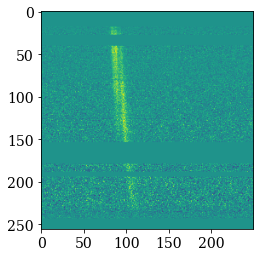

In [19]:
ar = np.load('GMRT_A_348.8_scrunch8_dt0.0003255599999999997sec_fchan256_bins250.npy')
plt.imshow(ar)
#plt.plot(ar.sum(0))

[11.62, 0.72, 0.85, 0.27, 13.54, 0.72, 1.23, 2.29, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
Raw Time Resolution (microsec):  325.56
Raw Frequency Resolution (kHz):  1562.5
WR:  140
WL:  50
Sampling Time (ms):  0.32556
Lower:  [5.81, 0.36, 0.42, 0.14, 6.77, 0.36, 0.61, 1.15, 0.0, 0.0, 0.0, 0.0]
Upper:  [17.43, 1.08, 1.27, 0.41, 20.31, 1.08, 1.84, 3.44, 1, 1, 1, 1]


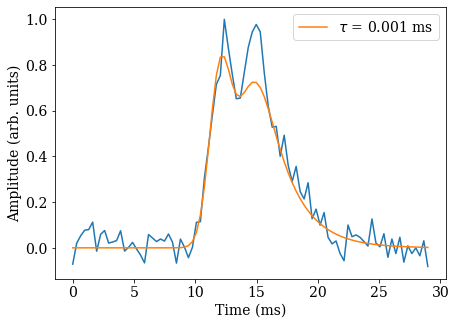

In [16]:
#Order: GBT A - 0, B - 1, C - 2, D - 3, E - 4, F - 5, G - 6, GMRT A - 7, B - 8, C - 9, D - 10
idx = 7
comp_num = 3
npy_file = npy_paths[idx]
               
#Updated fits post nested sampling
injection_csv = 'updatedfits_dict.csv'

# Read in csv containing initial conditions for each profile
with open(str(cwd) + '/' + str(injection_csv)) as csv_file:
    reader = csv.reader(csv_file)
    injection_dict = dict(reader)
    
p0_str = injection_dict[npy_file.split('/')[-1].split('_3')[0]]
p0 = [float(i) for i in p0_str.split('[')[1].split(']')[0].split(',')]
print(p0)

fil_durs = [83.34, 83.34, 333.37, 166.68, 83.34, 83.34, 83.34, 81.39, 81.39]

nested_sampling(npy_file, p0, comp_num = comp_num, file_duration = fil_durs[idx])